In [ ]:
!pip install rfpimp
!pip install eli5
!pip install cxplain
!git clone https://github.com/bondyra/pyBreakDown
%cd ./pyBreakDown
!python3 setup.py install
!pip install shap
!pip install lime

!pip install pdpbox
!pip install --upgrade scikit-learn
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install numpy --upgrade

In [204]:
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
from scipy.special import comb
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib as matplt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgbm
import scipy as sc

from pdpbox import pdp, get_dataset, info_plots
from alepython import ale_plot

import rfpimp as rfpimp
import eli5 as eli5
import cxplain as cxplain
import shap as shap
import lime as lime

from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation

import os, sys
import warnings
from contextlib import contextmanager
from tqdm import tqdm
from timeit import default_timer as timer
from google.colab import drive
from copy import deepcopy
from IPython.utils import io

%load_ext autoreload
%autoreload 2
%pylab inline
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
sns.set_palette("tab10")
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
path_to_datasets = "/content/drive/MyDrive/6_sem/dyakonov/experiments/artificial/"
random_state = 99
np.random.seed(random_state)

# Implementation of functions used further   

In [65]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


def sec_to_date_string(time_last):
    h = time_last // (60 * 60)
    m = (time_last % (60 * 60)) // 60
    s = (time_last % (60 * 60)) % 60
    return '{0}h {1}min {2}sec'.format(h, m, s)


# For filter methods 

def f1_metric(model, X_valid, y_valid, sample_weights=None):
    return f1_score(y_valid, model.predict(X_valid))


def all_feature_interaction(clf, X, n_samples=1000):
    """Finds feature interaction value for each column in X.

    The FI value is the amount of the variance explained by 
    the interaction (difference between observed and no-interaction Partial Dependence)

    Parameters
    ----------
    X : pandas frame
    clf : must have predict and decision function

    Returns
    -------
    H2_all : numpy array
        All feature interaction in the same column order as given in X
    """
    preds = clf.predict(X).reshape(-1, 1)
    pd_one_m = pd_one(clf, X, n_samples)
    pd_all_exc_one_m = pd_all_exc_one(clf, X, n_samples)

    norm_term = np.sum(np.square(preds))

    H2_all = np.sum(np.square(preds - pd_one_m - pd_all_exc_one_m), axis=0) / norm_term

    return H2_all.ravel()


def pd_all_exc_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(all_variables_except_j == values in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """

    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        uni = X.iloc[:, col_i].unique()
        if uni.shape[0] > n_samples:
            uni = np.random.choice(uni, n_samples, replace=False)
        nunique.append(uni)

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            preds = []
            for uniq in nunique[i]:
                mrow = row
                mrow[i] = uniq
                preds.append(clf.predict(mrow.reshape(1, -1)))
            answer[ind_r, i] = np.array(preds).mean()
        ind_r += 1
    return answer


def pd_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(j_variable == value in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """
    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        nunique.append(X.iloc[:, col_i].unique())

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            samples_not_i = np.empty((n_samples, num_cols - 1))
            for j in range(num_cols - 1):
                add_ind = 0
                if (j > i):
                    add_ind = 1

                samples_not_i[:, j] = np.random.choice(nunique[j + add_ind], size=n_samples)

            data = np.hstack((samples_not_i[:, :j], np.full((n_samples, 1), row[i]), samples_not_i[:, j:]))
            answer[ind_r, i] = clf.predict(data).mean()
        ind_r += 1
    return answer


# For experiments 

def rfpimp_dt_im(clf=None, X_valid=None, y_valid=None, metric=None, **kwargs):

    if clf is None or \
        X_valid is None or \
        y_valid is None or \
        metric is None:
        raise TypeError("One of the arguments is not set")

    im = rfpimp.importances(clf, X_valid, y_valid, metric=metric)
    for i in range(99):
        im += rfpimp.importances(clf, X_valid, y_valid, metric=metric)
    im /= 100
    im.columns = ['rfpimp (permutation)']
    return im


def eli5_dt_im(clf=None, X_train=None, **kwargs):

    if clf is None or \
        X_train is None:
        raise TypeError("One of the arguments is not set")
    
    p = None
    try:
        p = eli5.explain_weights_lightgbm(clf, importance_type='gain')
        im = p.feature_importances.importances
        fi = pd.DataFrame(index=X_train.columns, columns=['eli5 (gain)'])
        for el in im:
            fi.loc[el.feature] = el.weight
        return fi
    except:
        pass
    
    try:
        def replace_to_name(x):
            return X_train.columns[int(x[1:])]

        p = eli5.explain_weights_df(clf)
        p = p[p['feature'] != '<BIAS>']
        p['feature'] = p.feature.apply(replace_to_name)
        del p['target']
        p.columns = ['index', 'eli5']
        p.set_index('index', inplace=True)
        return p
    except:
        pass
    
    if p is None:
        raise ValueError('Wrong type of clf')
    


def pyBreakDown_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    exp = Explainer(clf=clf, data=X_train, colnames=X_train.columns)
    fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
    for i in range(X_valid.shape[0]):
        explanation = exp.explain(X_valid.values[i, :], direction='up')
        for attr in explanation._attributes:
            fi.iloc[i][attr.name] = attr.contribution
    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['pyBreakDown (up)'])
    return fi


def shap_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    explainer = None
    im = None
    try:
        explainer = shap.explainers.Tree(clf, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid)), axis=0)
        fi = pd.DataFrame(data=pd.Series(data=im, index=X_train.columns), columns=['shap (Tree)'])
        return fi
    except:
        pass
    
    try:
        explainer = shap.KernelExplainer(clf.predict_proba, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid, nsamples=100)[0]), axis=0)
        fi = pd.DataFrame(data=pd.Series(data=im, index=X_train.columns), columns=['shap (Kernel)'])
        return fi
    except:
        pass
    
    if explainer is None:
        raise ValueError('Wrong type of clf')


def lime_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, random_state=random_state)
    fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
    for i in range(X_valid.shape[0]):
        explanation = explainer.explain_instance(X_valid.values[i, :], clf.predict_proba).as_list()
        ind_c = 0
        for attr in explanation:
            fi.iloc[i][X_valid.columns[ind_c]] = attr[1]
            ind_c += 1
    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['lime'])
    return fi


def get_feature_importances(clf, X_train, X_valid, y_valid, metric):
    all_fi = pd.DataFrame(index=X_train.columns)

    # add rfpimp
    # average by 100 runs
    im = rfpimp_dt_im(clf, X_valid, y_valid, metric)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add eli5
    im = eli5_dt_im(clf, X_train)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add pyBreakDown
    im = pyBreakDown_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add shap 
    im = shap_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add lime
    im = lime_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    return all_fi.fillna(0)


def mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test,
                       num_iter=100, sample_size=[0.3, 0.5, 0.7], metric=f1_score):
    '''Computes mean metric value by sampling features according to their 
    normolized importance and evaluating on train/test sets. Sampled size 
    is equal to percent * (amount of all columns). 
    
    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    norm_all_fi: pandas DataFrame
        Rows: columns of dataset, columns: names of feature importance methods
        Value in cell = importance of accroding (column, method)
    num_iter: int
        The amount of times to repeat sample columns
    sample_size: list
        Percents of columns to sample 
    metric: function like "f1_metric(y_true, y_predicted)"
        Return score 

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    results = pd.DataFrame(columns=list(norm_all_fi.columns) + ['sample_size'])
    setup = {
        'num_iter': num_iter,
        'sample_size': sample_size
    }
    inds = list(norm_all_fi.index)
    count_cols = len(X_test.columns)

    ind = 0
    for sample_s in setup['sample_size']:
        count_samples = int(np.ceil(count_cols * sample_s))
        real_count_it = setup['num_iter']
        
        # check if num_iter too big
        # if (comb(count_cols, count_samples) < real_count_it):
        #     real_count_it = int(comb(count_cols, count_samples))

        for _ in range(real_count_it):
            scores = []
            for alg in norm_all_fi.columns:
                mask_p = np.where(norm_all_fi[alg].values == 0)[0]
                max_size = len(inds) - len(mask_p)
                real_size = np.min([max_size, count_samples])
                cur_cols = np.random.choice(inds, size=real_size, replace=False, p=list(norm_all_fi[alg].values))
                
                if count_samples > real_size:
                    zero_cols = [inds[i] for i in mask_p]
                    cur_cols = np.hstack([cur_cols, np.random.choice(zero_cols, size=count_samples-real_size, replace=False)])

                temp_clf = clf
                temp_clf.fit(X_train[cur_cols], y_train)
                scores.append(metric(y_test, temp_clf.predict(X_test[cur_cols])))
            results.loc[ind] = scores + [sample_s]
            ind += 1
    return results


def plot_setup_1(results, params):
    len_s = len(params['sample_size'])
    fig, axs = plt.subplots(len_s, 1, figsize=(10, len_s * 5))

    for ind in range(len_s):
        s_size = params['sample_size'][ind]
        axs[ind].boxplot(results[results['sample_size'] == s_size].values[:, :-1],
                        labels=results.columns[:-1], showfliers=False)

        axs[ind].set_title("Test f1 score depending on feature importance method on the selected features ({0}%)".format(int(s_size * 100)))
        axs[ind].set_xlabel("Feature importance method")
        axs[ind].set_ylabel("F1 score")
        axs[ind].grid(True)

    fig.tight_layout()
    fig.savefig(path_to_datasets + "f1_feature_size.pdf", bbox_inches='tight')
    return axs


def RFE(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
        X_test, y_test, final_size=0.5):
    '''On each iteration eliminates the least important variable

    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    importance: pandas DataFrame
        1 column: name of method, n_cols raws: names of predictors
    metric: function like "f1_metric(model, X_valid, y_valid, sample_weights)"

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    params = {
        'clf': clf,
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test,
        'metric': metric
    }
    info = []
    end_size = int(np.ceil(X_train.shape[1] * final_size))
    cur_cols = X_train.columns

    while len(cur_cols) != end_size - 1:
        params['X_train'] = X_train.loc[:, cur_cols]
        params['X_valid'] = X_valid.loc[:, cur_cols]
        params['X_test'] = X_test.loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        score = metric(clf, params['X_test'], y_test)
        info.append([im, score])

        selected_cols = im[im.columns[0]].abs().sort_values(ascending=False).iloc[:-1].index
        cur_cols = selected_cols
    
    return info


def setup_2(clf, im_methods, metric, X_train, y_train, X_valid, y_valid, 
            X_test, y_test, final_size=0.5):
    results = []
    for method in im_methods:
        result = RFE(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                      X_test, y_test, final_size)
        results.append(result)
    return results


def plot_setup_2(scores, im_names_methods, fmts, name=''):
    fig, ax = plt.subplots(figsize=(10, 5))

    ind = 0
    for m_scores in scores:
        ax.plot(np.arange(len(m_scores)), m_scores, fmts[ind], label=im_names_methods[ind])
        ind += 1

    ax.set_title('Test f1 score depending on the number of columns removed')
    ax.set_ylabel('F1 score')
    ax.set_xlabel('Number of columns removed')
    ax.grid(True)

    ax.legend()
    ax.autoscale_view()
    ax.xaxis.set_major_locator(matplt.ticker.MaxNLocator(integer=True))
    fig.savefig(path_to_datasets + 'RFE_f1_' + name + '.pdf', bbox_inches='tight')
    return ax


def original_copy_importances(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
                              X_test, y_test, final_size=0.5):
    '''
    Returns name of importance method and list of [importance_original_variable, importance_copy_variable]
    '''
    params = {
        'clf': clf,
        'X_train': deepcopy(X_train),
        'y_train': deepcopy(y_train),
        'X_valid': deepcopy(X_valid),
        'y_valid': deepcopy(y_valid),
        'X_test': deepcopy(X_test),
        'y_test': deepcopy(y_test),
        'metric': deepcopy(metric)
    }
    info = []
    name_im = None
    end_size = int(np.ceil(params['X_train'].shape[1] * final_size))
    cur_cols = params['X_train'].columns
    
    clf.fit(params['X_train'], y_train)
    params['clf'] = clf

    im = importance(**params)

    im = im[im.columns[0]].abs().sort_values(ascending=False)
    copy_col_name = im.index[0]
    params['X_train'][copy_col_name + '_copy'] = params['X_train'][copy_col_name]
    params['X_valid'][copy_col_name + '_copy'] = params['X_valid'][copy_col_name]
    params['X_test'][copy_col_name + '_copy'] = params['X_test'][copy_col_name]

    cur_cols = params['X_train'].columns
    while len(cur_cols) != end_size - 1:
        params['X_train'] = params['X_train'].loc[:, cur_cols]
        params['X_valid'] = params['X_valid'].loc[:, cur_cols]
        params['X_test'] = params['X_test'].loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        if name_im is None:
            name_im = im.columns[0]
        im = im[im.columns[0]].abs().sort_values(ascending=False)
        im /= im.sum()
        
        index_im = list(im.index)
        ind_r = len(im.index) - 1

        while (index_im[ind_r] == copy_col_name or \
              index_im[ind_r] == copy_col_name + '_copy') \
              and ind_r != -1:
              ind_r -= 1
        
        info.append([im.loc[copy_col_name], im.loc[copy_col_name + '_copy']])
        if ind_r == -1:
            return name_im, info
        else:
            index_im.remove(index_im[ind_r])

        cur_cols = index_im

    return name_im, info


def setup_3(clf, im_methods, metric, X_train, y_train, X_valid, y_valid,
            X_test, y_test, final_size=0.5):
    results = []
    names_im = []
    for method in im_methods:
        name, result = original_copy_importances(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                                                    X_test, y_test, final_size)
        results.append(np.array(result))
        names_im.append(name)
    return names_im, results


def plot_setup_3(scores, im_names_methods, name=''):
    len_s = len(scores)
    fig, axs = plt.subplots(len_s, 1, figsize=(7, len_s * 4))

    for ind in range(len_s):
        origin = results[ind][:, 0]
        copy = results[ind][:, 1]
        index = np.arange(origin.shape[0])
        width = 0.20

        axs[ind].bar(index - width / 2, origin, width, label='original')
        axs[ind].bar(index + width / 2, copy, width, label='copy')

        axs[ind].set_title("Importances of the variables depending on the columns [{0}]".format(im_names_methods[ind]))
        axs[ind].set_xlabel("Number of columns removed")
        axs[ind].set_ylabel("Normalized importance")
        axs[ind].grid(False)
        axs[ind].grid(True, axis='y')
        axs[ind].legend()

    fig.tight_layout()
    fig.savefig(path_to_datasets + "original_copy_" + name + ".pdf", bbox_inches='tight')
    return axs

# Data

**Features**: n_groups with n_feature_per_group.  
Each group have **means = 0**, covariance matrix with **std = 1** and **correlations = some constant**  
Bigger group index - *bigger* correlation 

In [54]:
n_groups = 5
n_feature_per_group = 3
n_features = n_groups * n_feature_per_group

fill_ar = np.zeros((n_feature_per_group, n_feature_per_group))
blocks = []

for i in range(1, n_groups + 1):
    cov = np.eye(n_feature_per_group)
    cov[cov == 0] = (1 / (n_groups + 1)) * i
    block = [fill_ar for j in range(i - 1)] + [cov] + [fill_ar for j in range(i, n_groups)]
    blocks.append(block)

covs = np.block(blocks)

X = np.random.multivariate_normal(np.zeros(n_features), covs, size=1000)

**Target**: sigmoid( sum the first feature of each groups with equal probability ) >= thresh

In [55]:
mask = np.random.randint(0, 2, size=(X.shape[0], n_groups))
y = (X[:, [i for i in range(0, n_features, n_feature_per_group)]] * mask).sum(axis=1).reshape(-1, 1)
y = sc.special.expit(y)
med = 0.5 #np.median(y)
y[y >= med] = 1
y[y < med] = 0
y = y.astype(int)

In [56]:
data = pd.DataFrame(data=np.hstack([X, y]), 
                    columns=['gr' + str(i) + '_' + str(j) for i in range(1, n_groups + 1) for j in range(1, n_feature_per_group + 1)] + ['target'])
data.iloc[:, -1] = data.iloc[:, -1].astype('int32')
data

,gr1_1,gr1_2,gr1_3,gr2_1,gr2_2,gr2_3,gr3_1,gr3_2,gr3_3,gr4_1,gr4_2,gr4_3,gr5_1,gr5_2,gr5_3,target
0,0.688102,0.450394,-0.249069,0.218318,1.655266,0.909982,1.012802,0.123908,-0.507457,0.293172,0.553591,-0.789889,1.155175,0.408637,-0.093640,1
1,1.167595,-0.520384,0.809979,-1.071430,-1.347461,-1.783783,-0.450954,0.723548,0.241233,-0.864843,0.772517,-1.741524,0.469825,-0.454724,0.680113,1
2,0.534701,2.468992,-0.542750,0.617469,2.046982,1.823887,-1.932068,-1.041779,-1.091903,-0.219390,-0.720619,-0.178632,-0.912767,-0.379806,0.239120,1
3,1.380265,-1.233886,-0.321115,0.048932,0.379925,-0.071995,0.712351,1.053365,2.037530,-1.001851,0.555387,0.182795,-0.013665,-0.278934,-0.654818,1
4,-1.005857,-0.071461,-0.373599,-0.979092,-0.488983,0.366764,-1.583600,0.547004,2.026778,0.217941,0.572095,1.509755,1.076691,1.982546,1.363060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.545593,0.087117,-0.187566,-0.141054,0.174155,0.358598,-0.356806,-0.392733,-0.536722,0.037258,0.692983,-0.127668,1.045290,1.587836,0.854839,1
996,-0.654489,-2.141146,-1.622587,-1.416083,-0.610810,-0.052533,0.997680,0.984309,0.923796,1.148367,1.016051,1.085356,-1.493022,-0.938015,-1.676919,0
997,-1.379658,0.007886,-0.282038,0.775606,-0.005742,1.867436,-0.253892,-0.700265,-0.548781,-0.751277,-0.680245,-1.240501,-1.712076,-1.196996,-0.605810,1
998,-0.322180,0.671613,-0.833256,-0.195169,1.713020,0.311369,-0.312061,0.331325,0.593019,0.073310,0.216673,0.154751,0.200781,-0.232787,-0.147874,1


In [57]:
# Features that are important on the training set but not on the held-out set might cause the model to overfit.
X_, X_test, y_, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2,random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2,random_state=random_state)

In [58]:
clf = lgbm.LGBMClassifier(learning_rate=0.01, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.7216494845360826


# Filter methods

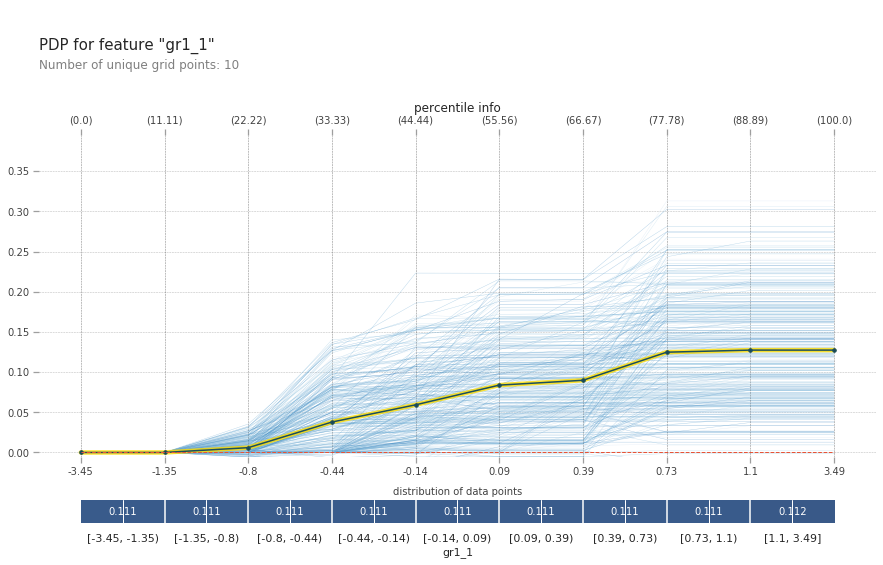

In [10]:
with suppress_stdout():
  pdp_Insulin = pdp.pdp_isolate(
    model=clf, dataset=X_train, model_features=X_train.columns, feature='gr1_1'
  )
  fig, axes = pdp.pdp_plot(
    pdp_Insulin, 'gr1_1', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
  ) 

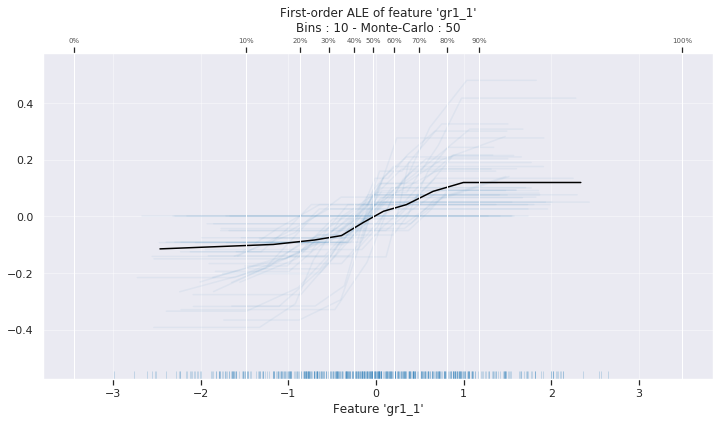

In [14]:
#fig, ax = plt.subplots(figsize=(12, 6))
ale_plot(clf, X_train, 'gr1_1', monte_carlo=True)
plt.show()

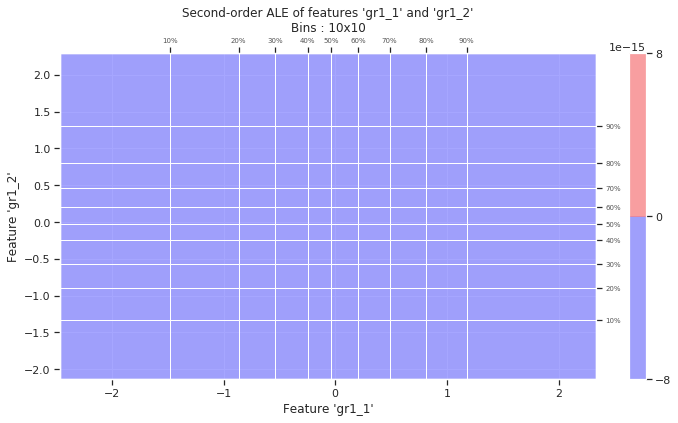

In [15]:
  ale_plot(clf, X_train, ['gr1_1', 'gr1_2'], monte_carlo=True)
plt.show()

In [16]:
start = timer()
f_ints = all_feature_interaction(clf, X_train, n_samples=100)
end = timer()

time_last = int(end - start)
print(sec_to_date_string(time_last))

0h 4min 43sec


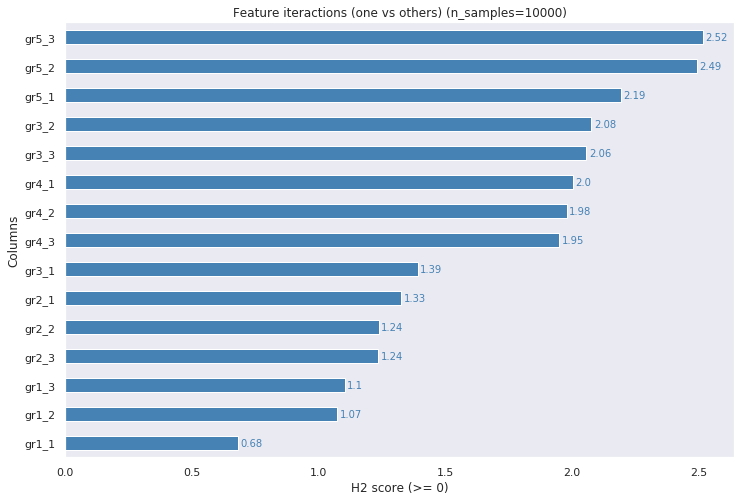

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

data = {'columns': X_train.columns, 
              'feature_interaction': f_ints}
data = pd.DataFrame(data,  index=data['columns'])
data.sort_values(by = "feature_interaction").plot(kind = "barh", color = "steelblue", legend = False, grid = True, ax = ax) 
plt.grid(False)
ax.set_title('Feature iteractions (one vs others) (n_samples=10000)')
ax.set_ylabel('Columns')
ax.set_xlabel('H2 score (>= 0)')

for i, v in enumerate(sorted(data.feature_interaction)):
    plt.text(v+0.01, i, str(round(v, 2)), color='steelblue', va="center")

$H_{j}^{2}=\sum_{i=1}^{n}\left[\hat{f}\left(x^{(i)}\right)-P D_{j}\left(x_{j}^{(i)}\right)-P D_{-j}\left(x_{-j}^{(i)}\right)\right]^{2} / \sum_{i=1}^{n} \hat{f}^{2}\left(x^{(i)}\right)$

# Working with libraries

#### Let's save all the importances things in the one table

In [18]:
all_fi = get_feature_importances(clf, X_train, X_valid, y_valid, f1_metric)
all_fi.reset_index(inplace=True)
all_fi.to_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8', index=False)
all_fi.set_index('index', inplace=True)
all_fi

,rfpimp (permutation),eli5 (gain),pyBreakDown (up),shap (Tree),lime
index,,,,,
gr1_1,0.073305,0.117078,0.00000,-0.254679,-0.025732
gr1_2,0.007969,0.015272,0.00000,0.015566,-0.025732
gr1_3,-0.004010,0.022003,0.00000,-0.032573,-0.025201
gr2_1,0.094670,0.272258,0.07500,0.065734,-0.020311
gr2_2,-0.003216,0.026476,0.00000,0.018174,-0.014339
gr2_3,-0.002525,0.009960,0.00000,-0.010103,-0.006826
gr3_1,0.053039,0.130570,-0.53125,-0.415863,-0.003136
gr3_2,-0.001626,0.014398,0.00625,0.008875,-0.000640
gr3_3,0.005563,0.035207,-0.01875,-0.083242,0.000498


#### Now we need only scores (positive and which are summed to 1)

In [128]:
norm_all_fi = (all_fi.abs() / all_fi.abs().sum(axis=0)).fillna(0)
norm_all_fi.reset_index(inplace=True)
norm_all_fi.to_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8', index=False)
norm_all_fi.set_index('index', inplace=True)
norm_all_fi.sort_values('shap (Tree)', ascending=False)

,rfpimp (permutation),eli5 (gain),pyBreakDown (up),shap (Tree),lime
index,,,,,
gr3_1,0.126416,0.130570,0.598592,0.323803,0.025584
gr1_1,0.174718,0.117078,0.000000,0.198301,0.209895
gr5_1,0.195268,0.115043,0.154930,0.132354,0.000000
gr4_2,0.040438,0.074898,0.063380,0.084669,0.000000
gr3_3,0.013259,0.035207,0.021127,0.064814,0.004062
gr2_1,0.225639,0.272258,0.084507,0.051182,0.165676
gr5_2,0.001767,0.039955,0.000000,0.041998,0.000000
gr1_3,0.009558,0.022003,0.000000,0.025362,0.205569
gr5_3,0.003830,0.030092,0.000000,0.025100,0.000000


In [20]:
# norm_all_fi = pd.read_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8')
# norm_all_fi.set_index('index', inplace=True)

# all_fi = pd.read_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8')
# all_fi.set_index('index', inplace=True)

In [179]:
pd_ind = 0
flatten_im = pd.DataFrame(columns=['feature', 'im_type', 'score'])
for i in range(len(d)):
    for j in range(1, len(d.iloc[0])):
        flatten_im.loc[pd_ind] = [d.iloc[i, 0],
                                  d.columns[j],
                                  d.iloc[i, j]]
        pd_ind += 1

first_features = flatten_im[flatten_im['feature'].str.contains('_1', regex=False)]

In [185]:
first_features.sample(5)

,feature,im_type,score
3,gr1_1,shap (Tree),0.198301
48,gr4_1,shap (Tree),0.001165
63,gr5_1,shap (Tree),0.132354
1,gr1_1,eli5 (gain),0.117078
30,gr3_1,rfpimp (permutation),0.126416


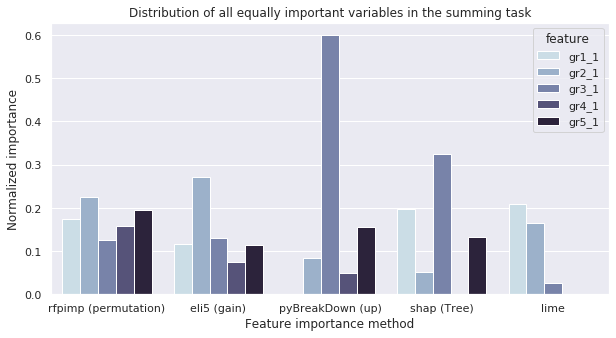

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x="im_type", y="score", hue="feature", data=first_features, palette='ch:s=.25,rot=-.25')
ax.set_title('Distribution of all equally important variables in the summing task')
ax.set_ylabel('Normalized importance')
ax.set_xlabel('Feature importance method')
fig.savefig(path_to_datasets + "TargetSum_impFeatures.pdf", bbox_inches='tight')
plt.show()

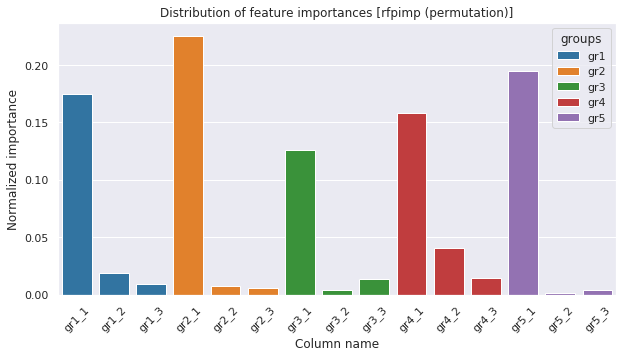

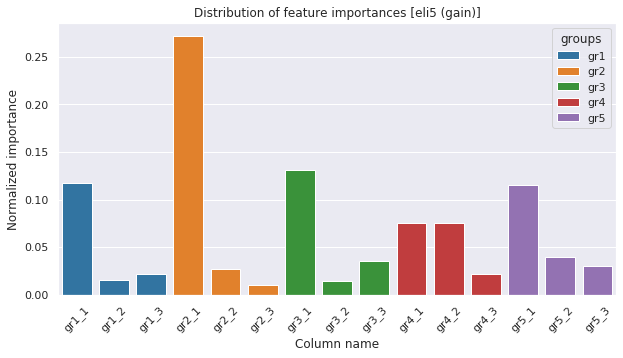

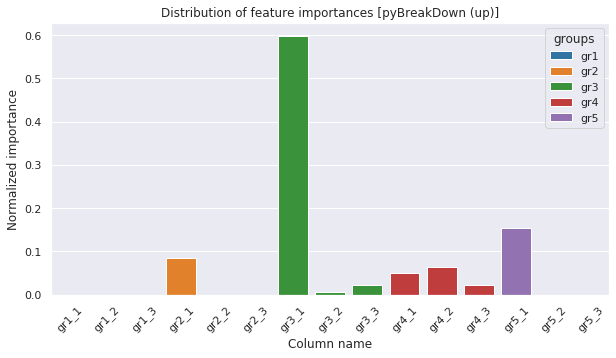

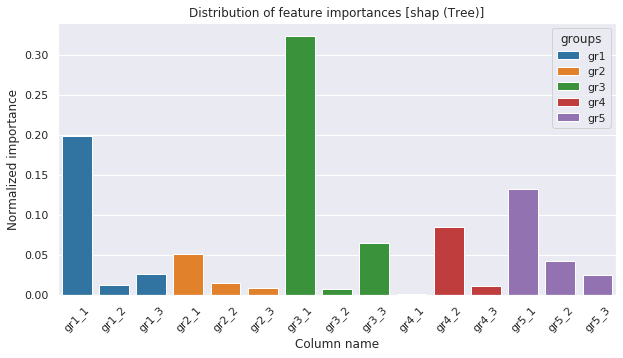

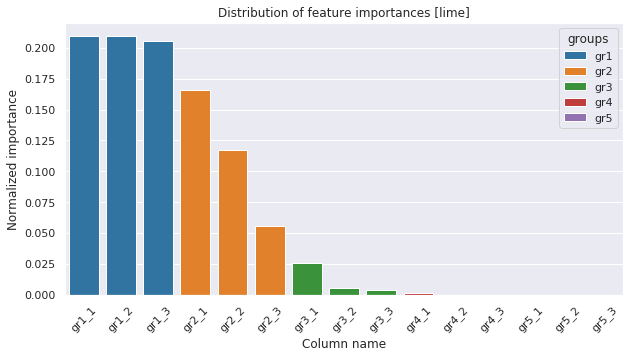

In [208]:
im_names_methods = ['rfpimp (permutation)', 'eli5 (gain)', 'pyBreakDown (up)', 'shap (Tree)', 'lime']

for name in im_names_methods:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.barplot(x="feature", y="score", data=flatten_im[flatten_im['im_type'] == name], 
                    hue=[i[:-2] for i in all_fi.index], dodge=False)
    ax.set_title('Distribution of feature importances [' + name + ']')
    ax.set_ylabel('Normalized importance')
    ax.set_xlabel('Column name')
    plt.legend(title='groups')
    plt.xticks(rotation=45)
    fig.savefig(path_to_datasets + 'TargetSum_allFeatures_' + name + '.pdf', bbox_inches='tight')
    plt.show()

**rfpimp (permutation)**: bigger correlation makes only 1 feature important  
**shap (Tree)**: opposite to *rfpimp (permutation)*  
**lime**: bigger correlation makes all features gradually unimportant

# Experiments

## Setup 1: Sampled feature importance
1. Calculate overall feature importance
2. Sample n percent features according to fi scores
3. Retrain base model, check metric

In [21]:
params = {
    'num_iter': 1000,
    'sample_size': [0.3, 0.5, 0.7]
}

begin = timer()
results = mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test, 
                             num_iter=params['num_iter'], sample_size=params['sample_size'], metric=f1_score)
end = timer()
print(sec_to_date_string(int(end - begin)))

0h 2min 59sec


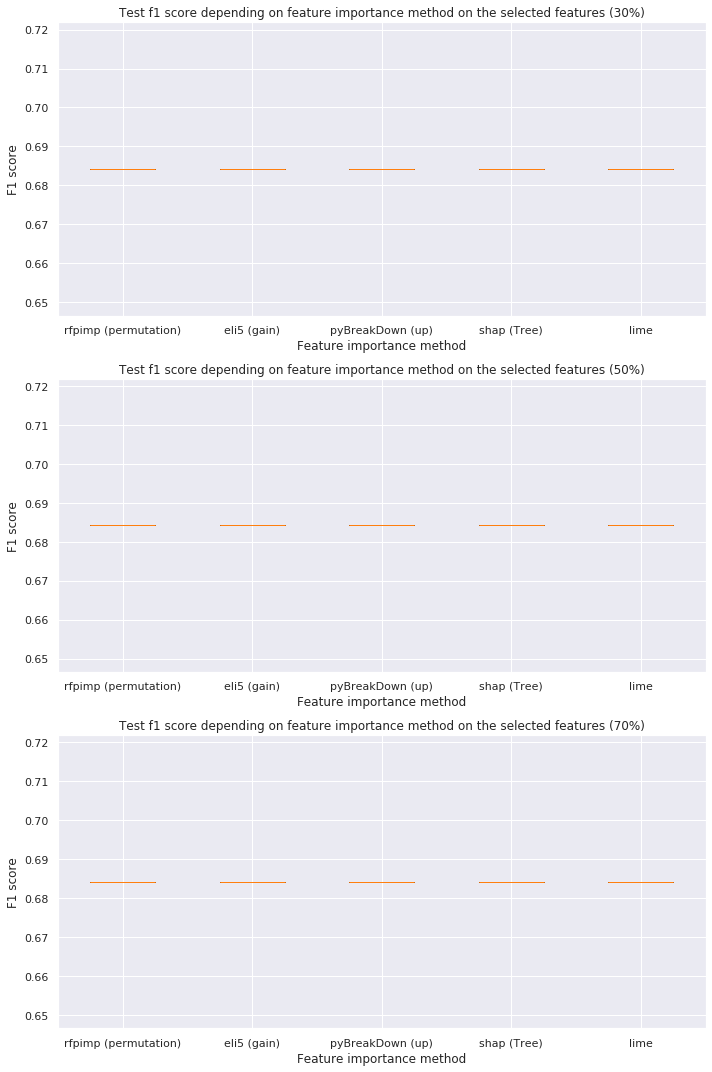

In [22]:
plot_setup_1(results, params)
plt.show()

## Setup 2: RFE

In [63]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]

begin = timer()
with io.capture_output() as captured:
    results = setup_2(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                      X_test, y_test, final_size=0.1)
end = timer()
print(sec_to_date_string(int(end - begin)))

scores = [[y[1] for y in z] for z in results]

1h 7min 12sec


In [ ]:
im_methods = [rfpimp_dt_im]
add_scores = []

for i in range(50):
    begin = timer()
    with io.capture_output() as captured:
        results = setup_2(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                        X_test, y_test, final_size=0.1)
    end = timer()
    print(sec_to_date_string(int(end - begin)))

    add_scores.extend([[y[1] for y in z] for z in results])

In [102]:
results = pd.DataFrame(columns=['n_removed', 'im_type', 'score'])

pd_ind = 0
for i in range(len(scores)):
    for j in range(len(scores[i])):
        results.loc[pd_ind] = [j, im_names_methods[i], scores[i][j]]
        pd_ind += 1

for i in range(len(add_scores)):
    for j in range(len(add_scores[i])):
        results.loc[pd_ind] = [j, im_names_methods[0], add_scores[i][j]]
        pd_ind += 1

In [109]:
results.sample(3)

,n_removed,im_type,score
708,8,rfpimp (permutation),0.748718
61,5,lime,0.715026
753,11,rfpimp (permutation),0.736842


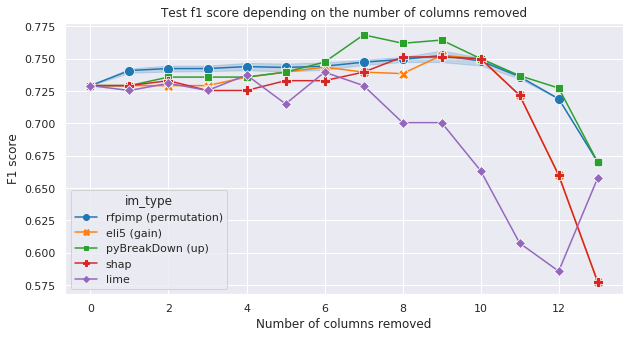

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    data=results,
    x="n_removed", y="score", hue="im_type", style="im_type",
    markers=True, dashes=False, ax=ax, markersize=10
)

ax.set_title('Test f1 score depending on the number of columns removed')
ax.set_ylabel('F1 score')
ax.set_xlabel('Number of columns removed')

fig.savefig(path_to_datasets + 'RFE_f1.pdf', bbox_inches='tight')
plt.show()

## Setup 3: Feature importance of copy
1. Take the most important variable on whole train dataset
2. Add copy of it to data
3. Remove the least important variable, besides variables at 1. and 2.
4. Check importances (sums to 1) of the remanings variables
5. Remember fi of variables at 1. and 2.


In [32]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]

begin = timer()
with io.capture_output() as captured:
    m_names, results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                            X_test, y_test, final_size=0.1)
end = timer()
print(sec_to_date_string(int(end - begin)))

0h 29min 7sec


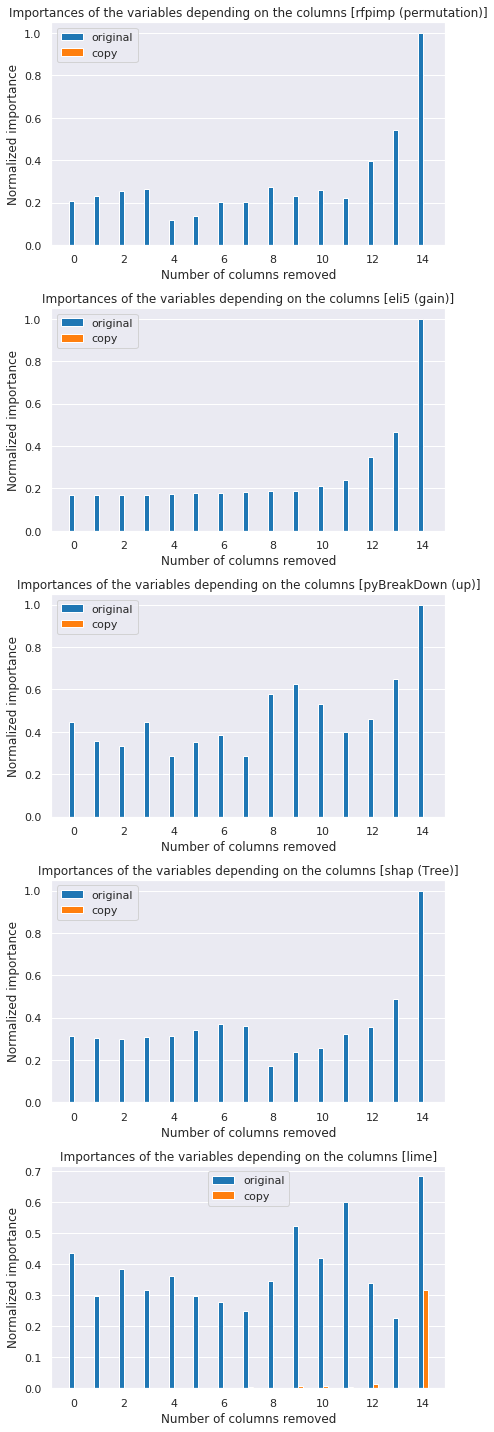

In [33]:
plot_setup_3(results, m_names, 'lgbm')
plt.show()

In [59]:
scaler = skl.preprocessing.StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train.iloc[:, :])
X_valid.iloc[:, :] = scaler.transform(X_valid.iloc[:, :])
X_test.iloc[:, :] = scaler.transform(X_test.iloc[:, :])

In [60]:
clf = skl.svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.7291666666666666


In [61]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]

begin = timer()
with io.capture_output() as captured:
    m_names, results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                            X_test, y_test, final_size=0.1)
end = timer()
print(sec_to_date_string(int(end - begin)))

1h 23min 19sec


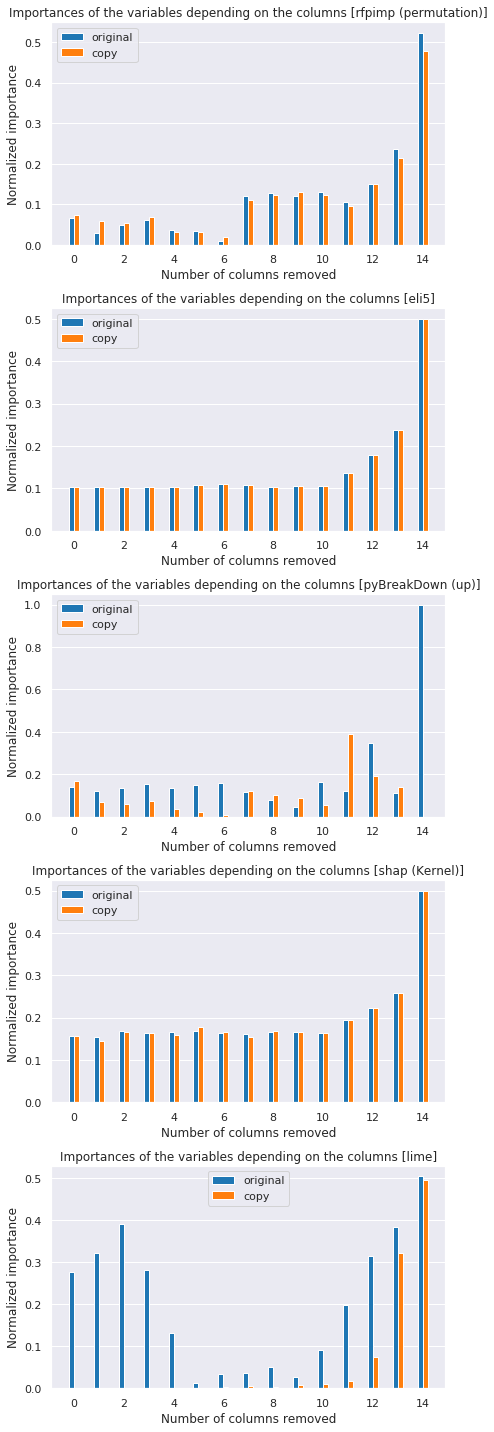

In [62]:
im_names_methods = ['rfpimp (permutation)', 'eli5', 'pyBreakDown (up)', 'shap (Kernel)', 'lime']
plot_setup_3(results, im_names_methods, 'svm')
plt.show()